In [68]:
import os

import random

import pandas as pd
import numpy as np
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno
from tqdm.notebook import tqdm
import json

import sklearn
import sklearn.model_selection
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import KNNWithMeans, SVD
from surprise import accuracy

import pickle

#Settings
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

#To be avoided in your notebook.
import warnings
warnings.filterwarnings("ignore")

# 1. Exploratory Data Analysis

## Dataset Content

* **articles_metadata.csv** : CSV file with metadata information about all (364047) published articles
* **articles_embeddings.pickle** : Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.
* **clicks** : Folder with CSV files (one per hour), containing user sessions interactions in the news portal.
* **clicks_sample.csv** : CSV file containing user sessions interactions in the news portal.

In [2]:
[print(x) for x in os.listdir('news-portal-user-interactions-by-globocom')];

articles_embeddings.pickle
articles_metadata.csv
clicks
clicks_sample.csv


## 1.1 **articles_metadata.csv**

### Content

In [3]:
PATH_ARTICLES_DATA = "news-portal-user-interactions-by-globocom/articles_metadata.csv"
articles_df = pd.read_csv(PATH_ARTICLES_DATA)

In [4]:
articles_df.head(5)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


**articles_metadata.csv contain 5 columns :**
* **article_id :** ID of the article
* **category_id :** Category ID of the article
* **created_at_ts :** Date of creation (timestamp)
* **publisher_id :** ID of the publisher
* **words_count :** Total word contain in the article

### Missing Values

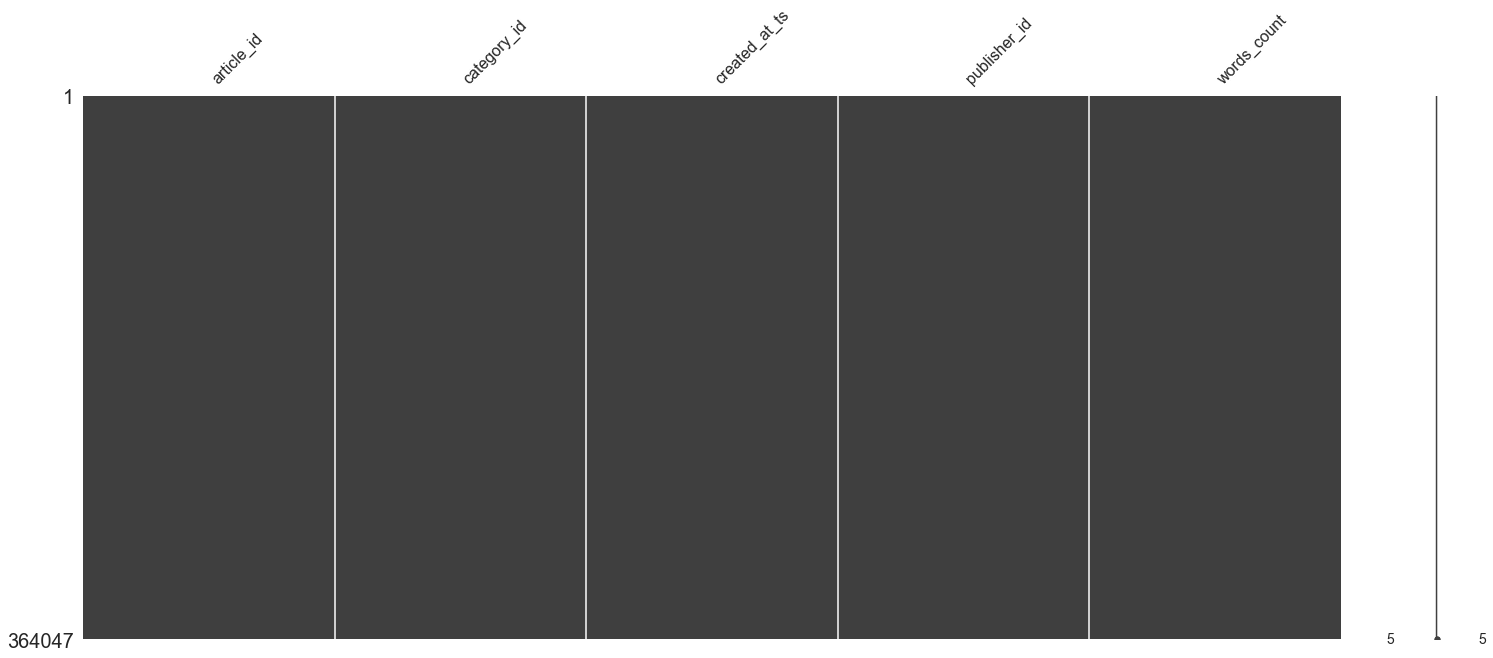

In [5]:
missingno.matrix(articles_df);

No value are missing.

In [6]:
articles_df['words_count'].describe()

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

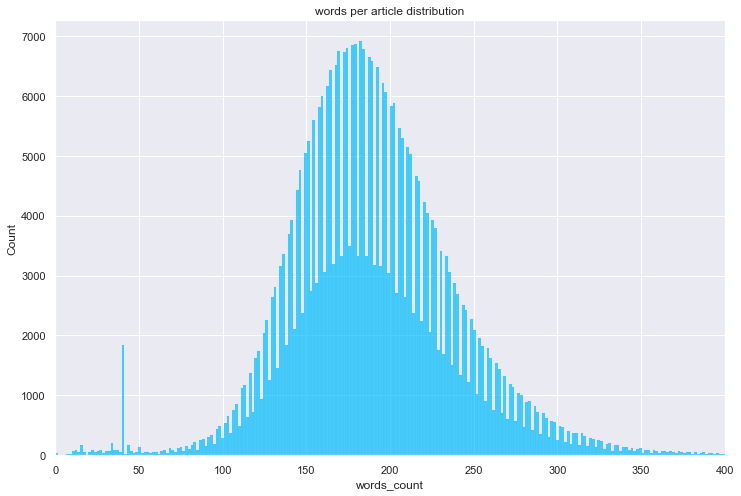

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['words_count'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.xlim([0,400])
plt.title('words per article distribution');
plt.show()

In [8]:
print(f'Empty article(s) : {articles_df[articles_df["words_count"] == 0].count()[0]}')

Empty article(s) : 35


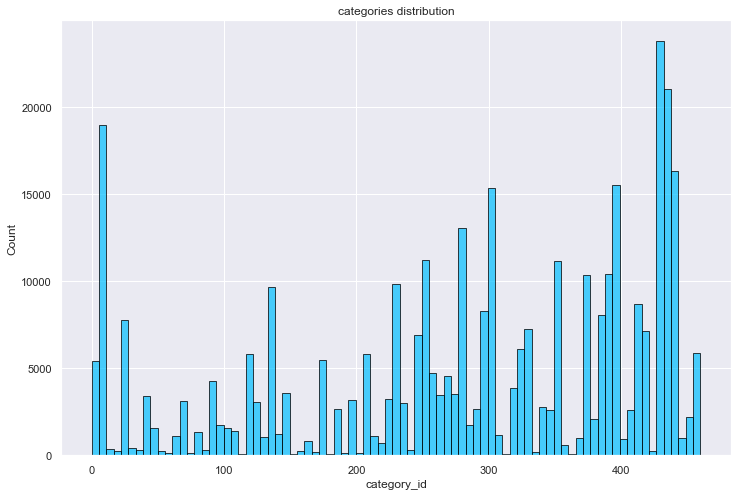

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['category_id'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.title('categories distribution');
plt.show()

## **1.2 clicks_{}.csv**

### Content

In [10]:
PATH_CLICK_SAMPLE_DATA = "news-portal-user-interactions-by-globocom/clicks_sample.csv"
clicks_samp_df = pd.read_csv(PATH_CLICK_SAMPLE_DATA)

In [11]:
clicks_samp_df.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [12]:
for session in clicks_samp_df.session_id:
    session_cliks = clicks_samp_df[clicks_samp_df.session_id == session]
    

<AxesSubplot:>

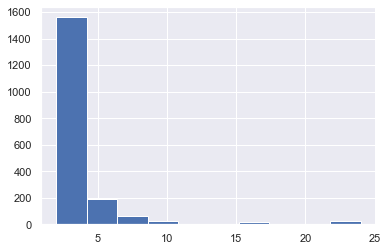

In [13]:
clicks_samp_df.session_size.hist()

In [14]:
[print(x) for x in clicks_samp_df.columns];

user_id
session_id
session_start
session_size
click_article_id
click_timestamp
click_environment
click_deviceGroup
click_os
click_country
click_region
click_referrer_type


**clicks_{}.csv contain 12 columns :**
* **user_id :** user ID
* **session_id :** Session ID
* **session_start :** Start of the session (timestamp)
* **session_size :** number of click/session
* **words_count :** Total word contain in the article
* **click_article_id :** article ID user clicked
* **click_timestamp :** When user clicked (timestamp)
* **click_environment :** user env when click
* **click_deviceGroup :** user device
* **click_os :** user OS
* **click_country :** localisation (country) when user clicked
* **click_region :** localisation (region) when user clicked
* **click_referrer_type :** ?

### Distribution
#### let's concat all clicks files and observe our datas

In [15]:
%%time

CLICK_FILES_PATH = "news-portal-user-interactions-by-globocom/clicks/"

#Get all .csv contain in clicks folder
click_files = [CLICK_FILES_PATH + x for x in os.listdir(CLICK_FILES_PATH)];

#Sort all files PATH contain in list.
click_files.sort()

#Check if all files are present.
print("Total PATH contain in list : ", len(click_files))

list_click_file_to_df = [pd.read_csv(x, index_col=None, header=0) for x in click_files];

#Remove unused columns
list_click_file_to_df_cleaned = [x.drop(columns = ['session_id',
                                                   'session_start',
                                                   'session_size',
                                                   #'click_timestamp',
                                                   'click_environment',
                                                   'click_deviceGroup',
                                                   'click_os',
                                                   'click_country',
                                                   'click_region',
                                                   'click_referrer_type']) for x in list_click_file_to_df]

all_clicks_df = pd.concat(list_click_file_to_df_cleaned, axis=0, ignore_index=True)

print(f"DataFrame shape : {all_clicks_df.shape}")

Total PATH contain in list :  385
DataFrame shape : (2988181, 3)
CPU times: total: 4.47 s
Wall time: 7.34 s


In [16]:
all_clicks_df

,user_id,click_article_id,click_timestamp
0,0,157541,1506826828020
1,0,68866,1506826858020
2,1,235840,1506827017951
3,1,96663,1506827047951
4,2,119592,1506827090575
...,...,...,...
2988176,10051,84911,1508211557302
2988177,322896,30760,1508211672520
2988178,322896,157507,1508211702520
2988179,123718,234481,1508211513583


In [17]:
articles = all_clicks_df.click_article_id.value_counts().index
articles_df = articles_df.iloc[articles]

# 2. Build our Recommendation Models

**[Helpful link : build-recommendation-engine-collaborative-filtering](https://realpython.com/build-recommendation-engine-collaborative-filtering/)**

## 2.1 Data Preparation
For our recommendation model we need to find a scoring system to help the model understand the preferences of each user.

I decided to proceed like that : **Rating = Total_Click_Per_Cat_By_User / Total_Click_Done_By_User**

In [18]:
len(all_clicks_df)

2988181

In [19]:
#Create a map to convert article_id to category
dict_article_categories = articles_df.set_index('article_id')['category_id'].to_dict()

all_clicks_df['total_click'] = all_clicks_df.groupby(['user_id'])['click_article_id'].transform('count')
all_clicks_df['total_click_on_article_id'] = all_clicks_df.groupby(['user_id','click_article_id'])['click_article_id'].transform('count')
all_clicks_df['art_rating'] = all_clicks_df['total_click_on_article_id'] / all_clicks_df['total_click']

#Get Categorie associate for each article
all_clicks_df['category_id'] = all_clicks_df['click_article_id'].map(dict_article_categories).astype(int)
all_clicks_df['total_click_by_category_id'] = all_clicks_df.groupby(['user_id','category_id'])['click_article_id'].transform('count')
all_clicks_df['cat_rating'] = all_clicks_df['total_click_by_category_id'] / all_clicks_df['total_click']

print(f'Shape before dropping duplicate : {all_clicks_df.shape}')
#all_clicks_df = all_clicks_df.drop(['click_article_id'], axis=1)
all_clicks_df = all_clicks_df.drop_duplicates()
print(f'Shape after dropping duplicate : {all_clicks_df.shape}')

Shape before dropping duplicate : (2988181, 9)
Shape after dropping duplicate : (2988181, 9)


In [20]:
all_clicks_df

,user_id,click_article_id,click_timestamp,total_click,total_click_on_article_id,art_rating,category_id,total_click_by_category_id,cat_rating
0,0,157541,1506826828020,8,1,0.125000,281,2,0.250000
1,0,68866,1506826858020,8,1,0.125000,136,1,0.125000
2,1,235840,1506827017951,12,1,0.083333,375,2,0.166667
3,1,96663,1506827047951,12,1,0.083333,209,1,0.083333
4,2,119592,1506827090575,4,1,0.250000,247,1,0.250000
...,...,...,...,...,...,...,...,...,...
2988176,10051,84911,1508211557302,49,1,0.020408,174,15,0.306122
2988177,322896,30760,1508211672520,2,1,0.500000,26,1,0.500000
2988178,322896,157507,1508211702520,2,1,0.500000,281,1,0.500000
2988179,123718,234481,1508211513583,14,1,0.071429,375,8,0.571429


In [21]:
#Remove unused columns
all_clicks_df = all_clicks_df.drop(['total_click', 'total_click_by_category_id', 'total_click_on_article_id'], axis=1)

all_clicks_df[all_clicks_df['user_id'] == 0]

,user_id,click_article_id,click_timestamp,art_rating,category_id,cat_rating
0,0,157541,1506826828020,0.125,281,0.250
1,0,68866,1506826858020,0.125,136,0.125
1287361,0,96755,1507340033155,0.125,209,0.125
1287362,0,313996,1507340063155,0.125,431,0.125
1352197,0,160158,1507388090915,0.125,281,0.250
1352198,0,233470,1507388120915,0.125,375,0.125
1535240,0,87224,1507514056617,0.125,186,0.250
1535241,0,87205,1507514086617,0.125,186,0.250


<AxesSubplot:>

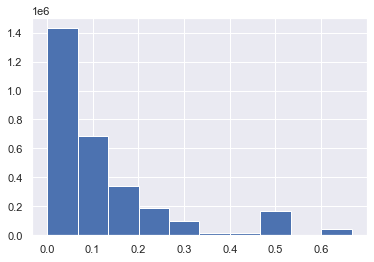

In [22]:
import scipy
all_clicks_df['hmean_rating'] = scipy.stats.hmean(all_clicks_df[['cat_rating', 'art_rating']], axis=1)
all_clicks_df['hmean_rating'].hist()

<AxesSubplot:>

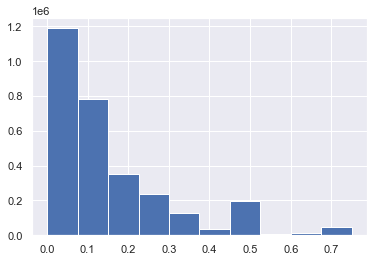

In [23]:
all_clicks_df['mean_rating'] = all_clicks_df[['cat_rating', 'art_rating']].mean(axis=1)
all_clicks_df['mean_rating'].hist()

We don't need Total_click and total_click_by_category_id anymore.

In [24]:
all_clicks_df

,user_id,click_article_id,click_timestamp,art_rating,category_id,cat_rating,hmean_rating,mean_rating
0,0,157541,1506826828020,0.125000,281,0.250000,0.166667,0.187500
1,0,68866,1506826858020,0.125000,136,0.125000,0.125000,0.125000
2,1,235840,1506827017951,0.083333,375,0.166667,0.111111,0.125000
3,1,96663,1506827047951,0.083333,209,0.083333,0.083333,0.083333
4,2,119592,1506827090575,0.250000,247,0.250000,0.250000,0.250000
...,...,...,...,...,...,...,...,...
2988176,10051,84911,1508211557302,0.020408,174,0.306122,0.038265,0.163265
2988177,322896,30760,1508211672520,0.500000,26,0.500000,0.500000,0.500000
2988178,322896,157507,1508211702520,0.500000,281,0.500000,0.500000,0.500000
2988179,123718,234481,1508211513583,0.071429,375,0.571429,0.126984,0.321429


In [25]:
#Remove unused columns
all_clicks_df = all_clicks_df.drop(['category_id', 'art_rating', 'cat_rating', 'mean_rating'], axis=1)

all_clicks_df[all_clicks_df['user_id'] == 0]

,user_id,click_article_id,click_timestamp,hmean_rating
0,0,157541,1506826828020,0.166667
1,0,68866,1506826858020,0.125000
1287361,0,96755,1507340033155,0.125000
1287362,0,313996,1507340063155,0.125000
1352197,0,160158,1507388090915,0.166667
1352198,0,233470,1507388120915,0.125000
1535240,0,87224,1507514056617,0.166667
1535241,0,87205,1507514086617,0.166667


In [26]:
all_clicks_df['nb_cliks_user'] = all_clicks_df.groupby('user_id')['user_id'].transform('count')

In [27]:
"""
#keep ~42 000 users to build our model.
df = all_clicks_df[all_clicks_df['user_id'] < 42000]
print(f'size of our sample : {df.shape}')
"""

"\n#keep ~42 000 users to build our model.\ndf = all_clicks_df[all_clicks_df['user_id'] < 42000]\nprint(f'size of our sample : {df.shape}')\n"

In [28]:
#keep only users who clicked on more than 20 articles
df = all_clicks_df[all_clicks_df['nb_cliks_user'] > 20]
print(f'size of our sample : {df.shape}')

size of our sample : (1340326, 5)


In [42]:
users = df.user_id.unique().astype(int)
articles = df.click_article_id.unique().astype(int)
print('number of users :', len(users))
print('number of articles :', len(articles))

number of users : 33292
number of articles : 26287


<AxesSubplot:ylabel='Count'>

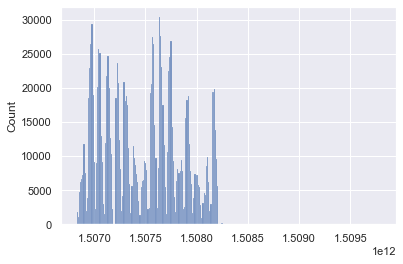

In [30]:
sns.histplot(df.click_timestamp.values)

<AxesSubplot:xlabel='user_id', ylabel='Count'>

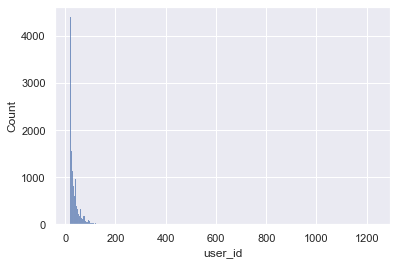

In [31]:
sns.histplot(df.user_id.value_counts())

In [32]:
ids_time_sorted = np.argsort(df.click_timestamp.values)

In [33]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)

for train_index, test_index in tscv.split(ids_time_sorted):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    test_df = df.iloc[test_index]
    train_df = df.iloc[train_index]

TRAIN: 268066 TEST: 268065
TRAIN: 536131 TEST: 268065
TRAIN: 804196 TEST: 268065
TRAIN: 1072261 TEST: 268065


In [40]:
print("users in train set :", len(df.iloc[train_index].user_id.unique()))
print("users in test set :", len(df.iloc[test_index].user_id.unique()))

users in train set : 33260
users in test set : 28730


In [43]:
m_user = ((test_df.user_id.value_counts() >= 5) & (train_df.user_id.value_counts() > 1))
users = users[m_user]
print("users present in train set with more than 5 clicks in test set :", m_user.sum())

users present in train set with more than 5 clicks in test set : 20497


In [44]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

#We build datsets from the split dataframes, so they conforme to the surprise models
train_set = Dataset.load_from_df(train_df[['user_id', 'click_article_id', 'hmean_rating']], reader)
train_set = train_set.build_full_trainset()

test_set = Dataset.load_from_df(test_df[['user_id', 'click_article_id', 'hmean_rating']], reader)
test_set = test_set.build_full_trainset().build_testset()

## 2.2 SVD (baseline)
### 2.3.1 Train Model

In [46]:
%%time

model = SVD().fit(train_set)

CPU times: total: 10.6 s
Wall time: 10.6 s


In [146]:
#anti_testset = train_set.build_anti_testset()

In [44]:
predict = model.test(test_set)

#Print our Results
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

print(f'Prediction rating for User 0 with article 157541 : {model.predict(5, 168868).est}')
print(f'Current rating : {df[(df["user_id"] == 5) & (df["click_article_id"] == 168868)]["hmean_rating"].values}')

RMSE: 0.0499
MSE: 0.0025
MAE:  0.0310
Prediction rating for User 0 with article 157541 : 0.062173442495222435
Current rating : [0.01149425]


### 2.3.3 Predictions with test set

In [47]:
articles_by_user_train = train_df[['user_id', 'click_article_id']].groupby('user_id').value_counts()

In [48]:
def make_recommandation(model, user, num=5):
    already_read = np.array(articles_by_user_train[user].index)
    pred_user = [model.predict(user, iid) for iid in articles]
    pred_user.sort(key=lambda x: x[3], reverse=False)
    i = 0
    pred_short = []
    while i<num:
        curr_pred = pred_user.pop()
        if curr_pred[1] not in already_read:
            pred_short.append(curr_pred[1])
            i+=1
    return pred_short

#%timeit make_recommandation(model, 5)
make_recommandation(model, 5)

[312102, 76009, 298328, 324423, 285556]

In [49]:
#Function from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

#top_n = get_top_n(predict, n=5)

In [84]:
test_df[['user_id', 'click_article_id']].groupby('user_id').value_counts()[25937]

click_article_id
271262    1
218028    1
235105    1
277107    1
313920    1
331116    1
dtype: int64

In [50]:
def get_top_n(model, users, num=5):
    recs = defaultdict(list)
    for uid in tqdm(users):
        recs[uid] = make_recommandation(model, uid, num)
    return recs
#top_n = get_top_n(model, users)

In [66]:
"""
with open('svd_recs.json', 'w') as f:
    json.dump(top_n, f)
"""

In [51]:
def load_predictions(json_file):    
    with open(json_file, 'r') as f:
            str_pred = json.load(f)
            pred = defaultdict(list)
            for user in str_pred:
                pred[int(user)] = str_pred[user]
    return pred

top_n = load_predictions('svd_recs.json')
len(top_n)

20497

In [52]:
print('recommendation for user 25937 :', top_n[25937])

recommendation for user 25937 : [102856, 273447, 115233, 166031, 21106]


In [76]:
articles_test = test_df.click_article_id.values
users_test = test_df.user_id.values

"""
print('via numpy :')
%timeit j = articles[users_test == 34979]
print('via numpy + unique test :')
%timeit j = np.unique(articles[users_test == 34979])
print('via pandas :')
%timeit j = test_df[test_df.user_id == 34979].click_article_id.values
print('via pandas + unique test :')
%timeit j = test_df.click_article_id[test_df.user_id == 34979].values
"""
articles_by_user_test = test_df[['user_id', 'click_article_id']].groupby('user_id').value_counts()

In [53]:
def get_read_article(uid, df):
    articles = df.click_article_id.values
    users = df.user_id.values
    return np.unique(articles[users == uid])

np.sort(get_read_article(32383, test_df))

array([209122, 211442], dtype=object)

In [54]:
def rate_prediction(predicted, real):
    return len([iid for iid in predicted if iid in real])/len(predicted)

rate_prediction(top_n[5], get_read_article(5, test_df))

0.0

In [55]:
def global_precision_score(pred, test_data):
    score = 0
    counter = 0
    articles_by_user = test_data[['user_id', 'click_article_id']].groupby('user_id').value_counts()
    for user in tqdm(pred):
        #print(type(user))
        recs = pred[user]
        real = np.array(articles_by_user[user].index)
        if len(real) >= len(recs):
            #print(user, recs, real, rate_prediction(recs, real))
            score += rate_prediction(recs, real)
            counter +=1
    print(counter, "users analysed")
    return score/counter

In [96]:
global_precision_score(top_n, test_df)

  0%|          | 0/20497 [00:00<?, ?it/s]

20451 users analysed


0.0001955894577282285

## 2.3 KNNWithMeans (Collaborative model)
### 2.3.1 Train Model

In [98]:
%%time 

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}

model_knn = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: total: 20 s
Wall time: 20.5 s


### 2.3.2 Results

In [99]:
predict = model_knn.test(test_set)

#Print our Results
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

RMSE: 0.0164
MSE: 0.0003
MAE:  0.0124


0.012359779205268831

### 2.3.3 Analyse des recommandations

In [100]:
#top_n_knn = get_top_n(model_knn, users, 5)

  0%|          | 0/20497 [00:00<?, ?it/s]

In [102]:
print('recommendation for user 5 :', top_n[5])

recommendation for user 5 : [132196, 110629, 297346, 117846, 293205]


In [103]:
"""
with open('knn_recs.json', 'w') as f:
    json.dump(top_n, f)
"""

In [56]:
top_n_knn = load_predictions('knn_recs.json')

In [57]:
top_n_knn[5]

[132196, 110629, 297346, 117846, 293205]

In [58]:
global_precision_score(top_n_knn, test_df)

  0%|          | 0/20497 [00:00<?, ?it/s]

20451 users analysed


0.0001955894577282285

In [108]:
top_n[5]

[132196, 110629, 297346, 117846, 293205]

In [67]:
print("recommandations pour l'utlisateur 5 avec KNNmeans :", top_n_knn[5])
print("recommandations pour l'utlisateur 5 avec SVD      :", top_n[5])

recommandations pour l'utlisateur 5 avec KNNmeans : [132196, 110629, 297346, 117846, 293205]
recommandations pour l'utlisateur 5 avec SVD      : [132196, 110629, 297346, 117846, 293205]


In [64]:
same_pred_counter = 0
for user in users:
    same_pred_counter += int(top_n[user] == top_n_knn[user])
same_pred_counter /= len(users)  / 100
print("pourcentage de recommandations identiques entre KNNmeans et SVD :", same_pred_counter)

pourcentage de recommandations identiques entre KNNmeans et SVD : 100.0


## 2.4 Content-Based Filtering

In [69]:
word_embed = pd.read_pickle('news-portal-user-interactions-by-globocom/articles_embeddings.pickle')
word_embed = word_embed[articles]
word_embed.shape

(26287, 250)

In [ ]:
def re